# Kaggle: Sberbank Russian Housing Prices Regression

- Try adjusting for inflation (and other metrics)
- Simply repetative variables
- Try filtering by VIF instead of correlation with price_doc
- Plot learning curves (accuracy vs train-test-split)
- Try linear regression with statsmodel OLS 
- Try naive xgb from kaggle kernels

In [50]:
#######################################
### Import Data Processing Packages ###
#######################################

import pandas            as pd;
import numpy             as np;
import seaborn           as sns;
import matplotlib.pyplot as plt;
import re;

import statsmodels.api as smf;

%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from scipy import stats;

from time import time

########################################
### Import Machine Learning Packages ###
########################################

from sklearn.preprocessing   import StandardScaler;
from sklearn.preprocessing   import PolynomialFeatures;

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV;
from sklearn.metrics         import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error;

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis;
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis;

from sklearn.linear_model    import LinearRegression;
from sklearn.linear_model    import LogisticRegression, LogisticRegressionCV;
from sklearn.linear_model    import Ridge, RidgeCV;
from sklearn.linear_model    import Lasso, LassoCV;
from sklearn.linear_model    import ElasticNet, ElasticNetCV;
from sklearn.linear_model    import TheilSenRegressor;
from sklearn.linear_model    import BayesianRidge;

from sklearn.neighbors       import KNeighborsClassifier;
from sklearn.tree            import DecisionTreeClassifier;
from sklearn.ensemble        import RandomForestClassifier;
from sklearn.svm             import SVC;
from sklearn.cluster         import KMeans;
from sklearn.decomposition   import PCA;

from sklearn.ensemble        import RandomForestRegressor;
from sklearn.ensemble        import GradientBoostingRegressor;
from sklearn.ensemble        import AdaBoostRegressor;

from sklearn.neural_network  import MLPClassifier;

from sklearn.pipeline import Pipeline;

import xgboost as xgb;

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

########################
### Import Data Sets ###
########################

#from sklearn                 import datasets;

In [26]:
# Read CSV Files
train_df = pd.read_csv('train.csv');
test_df  = pd.read_csv('test.csv');

# From here: https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity/notebook
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

macro_df = pd.read_csv('macro.csv', usecols=['timestamp'] + macro_cols)

# Check Head of Macro Data
macro_df.head()

# Check Head of Training Data
train_df.head()

# Check Column Names
#train_df.columns.values

# Check Column Names
#macro_df.columns.values

# Check column sizes and data types
#train_df.info(verbose=True)

# Check column sizes and data types
#macro_df.info()

# Check dimensions of dataframe
#train_df.shape

# Check dimensions of macro dataframe
#macro_df.shape

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [27]:
train_df = pd.merge_ordered(train_df, macro_df, on='timestamp', how='left')

train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,average_provision_of_build_contract,micex_rgbi_tr,micex_cbi_tr,deposits_rate,mortgage_value,mortgage_rate,income_per_cap,rent_price_4+room_bus,museum_visitis_per_100_cap,apartment_build
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,5.76,131.16,204.78,4.1,323275,11.84,42688.6,136.11,1240.0,23587.0
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,5.76,131.45,204.92,4.1,323275,11.84,42688.6,136.11,1240.0,23587.0
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,5.76,131.08,204.84,4.1,323275,11.84,42688.6,136.11,1240.0,23587.0
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,5.76,131.45,205.42,4.0,386388,11.92,40311.3,155.22,1240.0,23587.0
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,5.76,131.19,198.24,4.0,386388,11.92,40311.3,155.22,1240.0,23587.0


In [28]:
# Check training data for NaN values

#train_nan = train_df.isnull().sum(axis=0)
#print(train_nan[train_nan != 0])

In [29]:
# Check training data for NaN values

#train_nan[train_nan > 4000].index.values;

In [30]:
# Drop columns with lots of null entries

#train_df = train_df.drop(train_nan[train_nan > 4000].index.values, axis=1);

In [31]:
# Check macro data for NaN values

#macro_nan = macro_df.isnull().sum(axis=0);
#print(macro_nan[macro_nan != 0])

In [32]:
# Check training data for NaN values

#macro_nan[macro_nan > 290].index.values;

In [33]:
# Drop columns with lots of null entries

#macro_df = macro_df.drop(macro_nan[macro_nan > 270].index.values, axis=1);

In [34]:
# Inspect training data statistics of data

train_df.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,average_provision_of_build_contract,micex_rgbi_tr,micex_cbi_tr,deposits_rate,mortgage_value,mortgage_rate,income_per_cap,rent_price_4+room_bus,museum_visitis_per_100_cap,apartment_build
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04,30471.000000,30471.000000,30471.000000,13570.000000,27232.000000
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,...,6.116616,127.288885,237.868659,6.373824,6.811590e+05,12.532303,55778.022835,163.273194,1382.187988,44910.638807
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,...,0.200937,8.846174,14.060299,2.113760,4.559643e+05,0.652565,13041.480788,20.473868,70.691413,3854.550878
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,5.750000,97.860000,195.300000,4.000000,3.860600e+04,11.400000,33194.000000,100.080000,1240.000000,23587.000000
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,...,5.980000,122.950000,231.240000,5.190000,2.978570e+05,12.220000,47334.000000,149.100000,1309.000000,46080.000000
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,...,6.070000,128.630000,242.440000,5.540000,6.281630e+05,12.300000,52740.400000,160.690000,1440.000000,46080.000000
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,...,6.290000,133.470000,246.050000,6.100000,1.029124e+06,12.620000,58779.100000,174.220000,1440.000000,46352.000000
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,6.460000,141.650000,282.700000,12.330000,1.753294e+06,14.710000,89252.000000,212.870000,1440.000000,46352.000000


In [35]:
# Inspect macro data statistics of data

macro_df.describe()

,balance_trade,balance_trade_growth,eurrub,average_provision_of_build_contract,micex_rgbi_tr,micex_cbi_tr,deposits_rate,mortgage_value,mortgage_rate,income_per_cap,rent_price_4+room_bus,museum_visitis_per_100_cap,apartment_build
count,2453.000000,2394.000000,2481.000000,2484.000000,2474.000000,2483.000000,2070.000000,2.484000e+03,2484.000000,2191.000000,2211.000000,1461.000000,1826.000000
mean,15.344006,16.846742,50.444801,5.766268,129.026273,233.729046,6.296425,5.007981e+05,12.659308,51766.238932,166.754536,1245.543463,36282.434830
std,3.878104,16.988727,13.905912,0.536725,7.101521,35.581966,1.898185,3.946050e+05,0.655984,13310.709059,27.119071,162.526951,10761.669111
min,5.823000,-4.100000,37.445400,4.000000,97.860000,171.150000,4.000000,8.016000e+03,11.400000,29880.200000,100.080000,993.000000,22825.000000
25%,12.785000,7.200000,40.242600,5.750000,126.130000,205.295000,5.200000,1.791530e+05,12.220000,43706.450000,146.410000,1240.000000,23587.000000
50%,16.041000,10.500000,42.862200,5.940000,131.280000,233.000000,5.700000,4.241050e+05,12.550000,49388.700000,162.000000,1309.000000,42551.000000
75%,18.076000,21.500000,61.323700,6.070000,132.970000,248.390000,6.920000,7.660090e+05,12.990000,56073.500000,180.760000,1309.000000,46080.000000
max,21.939000,75.800000,90.881500,6.460000,141.650000,314.300000,12.330000,1.753294e+06,14.710000,102709.000000,250.300000,1440.000000,46352.000000


In [36]:
#########################
### Clean Up Outliers ###
#########################

train_df.loc[train_df['life_sq'] > 1000,     'life_sq']       = np.median(train_df['life_sq'].dropna());
train_df.loc[train_df['kitch_sq'] > 250,     'kitch_sq']      = np.median(train_df['kitch_sq'].dropna());
train_df.loc[train_df['num_room'] > 6,       'num_room']      = np.median(train_df['num_room'].dropna());
train_df.loc[train_df['build_year'] > 2017,  'build_year']    = np.median(train_df['build_year'].dropna());
train_df.loc[train_df['build_year'] < 1800,  'build_year']    = np.median(train_df['build_year'].dropna());
train_df.loc[train_df['floor'] > 50,         'floor']         = np.median(train_df['floor'].dropna());
train_df.loc[train_df['max_floor'] > 60,     'max_floor']     = np.median(train_df['max_floor'].dropna());
train_df.loc[train_df['metro_km_walk'] > 30, 'metro_km_walk'] = np.median(train_df['metro_km_walk'].dropna());

test_df.loc[test_df['life_sq'] > 1000,     'life_sq']       = np.median(test_df['life_sq'].dropna());
test_df.loc[test_df['kitch_sq'] > 250,     'kitch_sq']      = np.median(test_df['kitch_sq'].dropna());
test_df.loc[test_df['num_room'] > 6,       'num_room']      = np.median(test_df['num_room'].dropna());
test_df.loc[test_df['build_year'] > 2017,  'build_year']    = np.median(test_df['build_year'].dropna());
test_df.loc[test_df['build_year'] < 1800,  'build_year']    = np.median(test_df['build_year'].dropna());
test_df.loc[test_df['floor'] > 50,         'floor']         = np.median(test_df['floor'].dropna());
test_df.loc[test_df['max_floor'] > 60,     'max_floor']     = np.median(test_df['max_floor'].dropna());
test_df.loc[test_df['metro_km_walk'] > 30, 'metro_km_walk'] = np.median(test_df['metro_km_walk'].dropna());

In [37]:
###############################################
### Fill in Missing Values in Training Data ###
###############################################

train_nan = train_df.isnull().sum(axis=0);
columns_to_fill_in = train_nan[train_nan != 0].index.values;

for column in columns_to_fill_in:
    if train_df[column].dtype == 'O':
        train_df[column] = train_df[column].fillna(stats.mode(train_df[column].dropna().values)[0][0]);  
    else:
        train_df[column] = train_df[column].fillna(np.median(train_df[column].dropna()));
        
###########################################    
### Fill in Missing Values in Test Data ###
###########################################

test_nan = test_df.isnull().sum(axis=0);
columns_to_fill_in = test_nan[test_nan != 0].index.values;

for column in columns_to_fill_in:
    if test_df[column].dtype == 'O':
        test_df[column] = test_df[column].fillna(stats.mode(test_df[column].dropna().values)[0][0]);  
    else:
        test_df[column] = test_df[column].fillna(np.median(test_df[column].dropna()));
    
############################################
### Fill in Missing Values in Macro Data ###
############################################

macro_nan = macro_df.isnull().sum(axis=0);
columns_to_fill_in = macro_nan[macro_nan != 0].index.values;

for column in columns_to_fill_in:
    if macro_df[column].dtype == 'O':
        macro_df[column] = macro_df[column].fillna(stats.mode(macro_df[column].dropna().values)[0][0]);  
    else:
        macro_df[column] = macro_df[column].fillna(np.median(macro_df[column].dropna()));

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:250: RuntimeWarning:

The input array could not be properly checked for nan values. nan values will be ignored.



In [38]:
###################################################
### Convert Timestamp Object to DateTime Object ###
###################################################

train_df['timestamp'] =  pd.to_datetime(train_df['timestamp'])
test_df['timestamp']  =  pd.to_datetime(test_df['timestamp'])
macro_df['timestamp'] =  pd.to_datetime(macro_df['timestamp'])

In [39]:
################################################
### Convert 'Ecology' Column to Ordinal Data ###
################################################

train_df.loc[train_df['ecology'] == 'no data', 'ecology']     = float('NaN');
train_df.loc[train_df['ecology'] =='poor', 'ecology']         = 1;
train_df.loc[train_df['ecology'] =='satisfactory', 'ecology'] = 2;
train_df.loc[train_df['ecology'] =='excellent', 'ecology']    = 3;
train_df.loc[train_df['ecology'] =='good', 'ecology']         = 4;

test_df.loc[test_df['ecology'] =='no data', 'ecology']      = float('NaN');
test_df.loc[test_df['ecology'] =='poor', 'ecology']         = 1;
test_df.loc[test_df['ecology'] =='satisfactory', 'ecology'] = 2;
test_df.loc[test_df['ecology'] =='excellent', 'ecology']    = 3;
test_df.loc[test_df['ecology'] =='good', 'ecology']         = 4;

# Fill in NaN Data
train_df['ecology'] = train_df['ecology'].fillna(stats.mode(train_df['ecology'].values)[0][0])
test_df['ecology']  = test_df['ecology'].fillna(stats.mode(test_df['ecology'].values)[0][0])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning:

numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.



In [40]:
####################################### 
### Convert Yes, No to Ordinal Data ###
#######################################

yes_no_columns = ['culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion',
                  'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 
                  'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line']

for column in yes_no_columns:
    train_df.loc[train_df[column] =='no',  column] = 0;
    train_df.loc[train_df[column] =='yes', column] = 1;
    train_df[column] = pd.to_numeric(train_df[column]);
    
    test_df.loc[test_df[column] =='no',  column] = 0;
    test_df.loc[test_df[column] =='yes', column] = 1;
    test_df[column] = pd.to_numeric(test_df[column]);

In [41]:
##############################
### Create Dummy Variables ###
##############################

for column in train_df.loc[:, train_df.dtypes == object].columns.values:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[column])], axis=1);
    train_df = train_df.drop(column, axis=1);
    
for column in test_df.loc[:, test_df.dtypes == object].columns.values:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[column])], axis=1);
    test_df = test_df.drop(column, axis=1);

In [42]:
###############################################
### Convert Timestamp to a More Useful Form ###
###############################################

train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear;
train_df = train_df.drop('timestamp', axis=1);

test_df["yearweek"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.weekofyear;
test_df = test_df.drop('timestamp', axis=1);

In [43]:
######################################
### Drop Columns with Useless Data ###
######################################

train_df = train_df.drop('id', axis=1);

test_id = test_df['id'].values;
test_df = test_df.drop('id', axis=1);

In [44]:
train_df.shape

(30471, 450)

In [45]:
#####################################
### Simplify Repetative Variables ###
#####################################

to_simplify = ['cafe_count_500_price', 'cafe_count_1000_price', 'cafe_count_1500_price', 'cafe_count_2000_price', 
               'cafe_count_3000_price', 'cafe_count_5000_price', 'cafe_avg', 'min_price', 'max_price', 'na_price',
               'big_church_count', 'church_count', 'mosque_count', 'leisure_count', 'sport_count', 'office_count', 
               'market_count', 'trc_sqm', 'trc_count', 'prom_part', 'green_part']

for col_simplify in to_simplify:
    train_df[col_simplify] = 0;
    test_df[col_simplify] = 0;
    
    for column in train_df.columns.values:
        if column.find(col_simplify) > -1:
            train_df[col_simplify] = train_df[col_simplify] + train_df[column];
            test_df[col_simplify] = test_df[col_simplify] + test_df[column];
            train_df = train_df.drop(column, axis=1)
            test_df = test_df.drop(column, axis=1)

In [46]:
train_df.shape

(30471, 324)

In [23]:
############################################
### Remove Highly Uncorrelated Variables ###
############################################

for column in train_df.columns.values:
    if abs(train_df[column].corr(train_df['price_doc'])) < 0.1:
        train_df = train_df.drop(column, axis=1)
        if column in test_df.columns.values:
            test_df = test_df.drop(column, axis=1)

In [24]:
train_df.shape

(30471, 117)

In [47]:
######################################
### Log Normalize Skewed Variables ###
######################################

for column in train_df.columns.values:
    if stats.skew(train_df[column].values) > 1:
        train_df[column] = np.log(train_df[column] + 1)   
        if column in test_df.columns.values:
            test_df[column]  = np.log(test_df[column] + 1)   

In [48]:
##########################################
### Make Sure All Columns are the Same ###
##########################################

for column in train_df.drop('price_doc', axis=1).columns.values:
    if column not in test_df.columns.values:
        train_df = train_df.drop(column, axis=1);
        
for column in test_df.columns.values:
    if column not in train_df.columns.values:
        test_df = test_df.drop(column, axis=1);

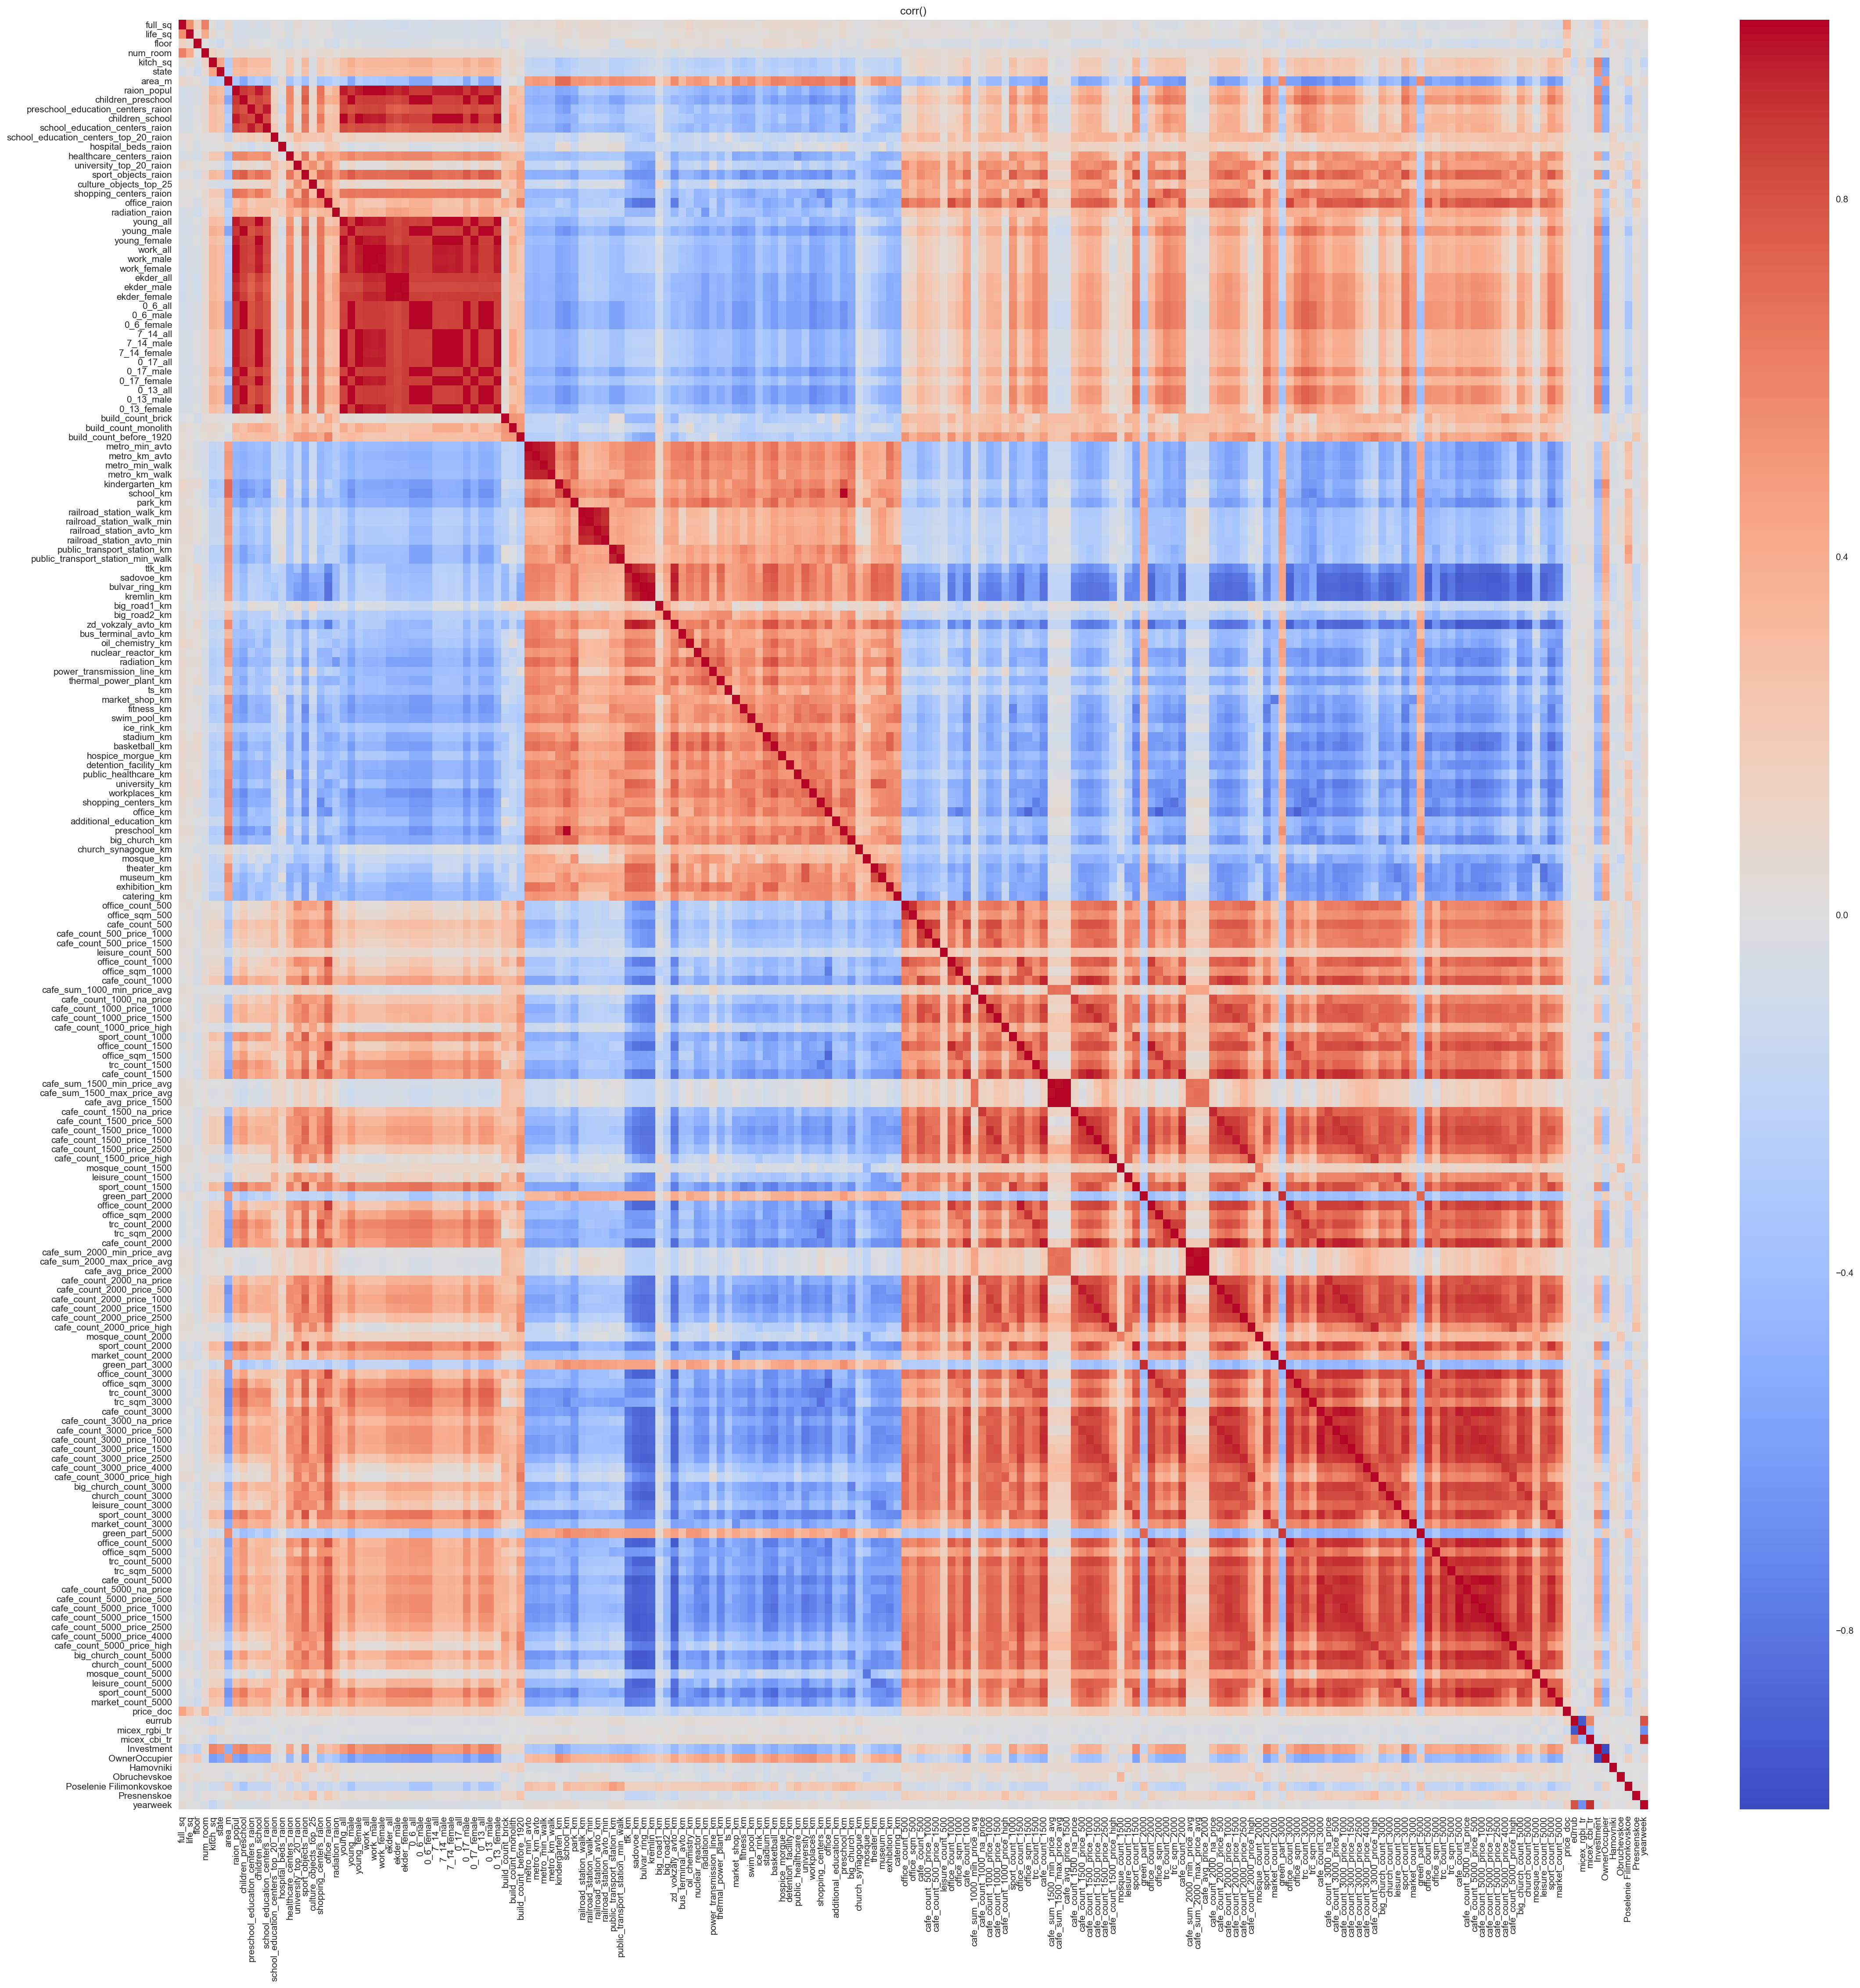

In [22]:
#####################################
### Training Data Correlation Map ###
#####################################

fig  = plt.figure(figsize=(36, 36), dpi=150);

axes1 = fig.add_subplot(111); 

sns.heatmap(train_df.corr(), ax=axes1, cmap='coolwarm')

plt.title('corr()')

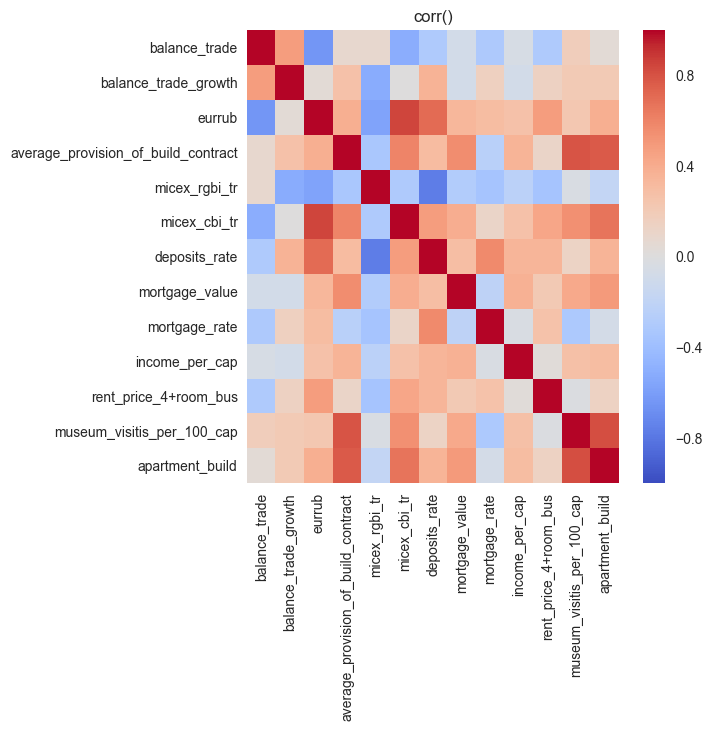

In [23]:
##################################
### Macro Data Correlation Map ###
##################################

fig  = plt.figure(figsize=(6, 6), dpi=100);

axes1 = fig.add_subplot(111); 

sns.heatmap(macro_df.corr(), ax=axes1, cmap='coolwarm')

plt.title('corr()')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



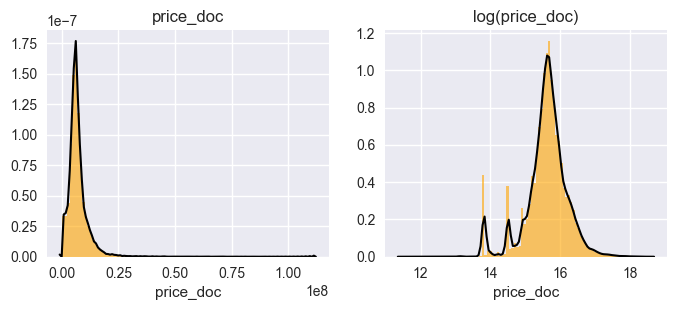

In [29]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot(np.exp(train_df['price_doc']),         bins=100, ax=axes1, axlabel='price_doc', kde_kws={"color": "k", "lw": 1.5}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot(train_df['price_doc'], bins=100, ax=axes2, axlabel='price_doc', kde_kws={"color": "k", "lw": 1.5}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("price_doc")
axes2.set_title("log(price_doc)")

In [51]:
vif = [variance_inflation_factor(train_df.values, i) for i in range(train_df.shape[1])]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning:

divide by zero encountered in double_scalars



In [52]:
print(vif)

[2.673484466624573, 1.5175981737899353, 1.3360242340111916, 1.6325165963674191, 1.2295459189012756, 1.7001824796051135, 1.9039852013207286, 2.0192662562941424, 1.627538908828853, 290554814669064.25, inf, inf, inf, 9007199254740992.0, 9007199254740992.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 3002399751580330.5, 3002399751580330.5, 4503599627370496.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 9007199254740992.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, 9007199254740992.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 5.0225370367787301, 66.225157011447109, 115.46024690949069, 83.67356862783835, 198.42391519346154, 12.419479345214112, 143.78513615721758, 15.987869121891451, 2.2437695691610329, 3.66191217440945, 144.89966764691863, 5.1490727825792604, 76.176018397626351, 234.33000714402175, 151.21319405155035, 6.3749822013926378, 65.446825191022882, 50.844384

In [60]:
df_vif = pd.DataFrame(vif, train_df.columns)
df_vif.columns = ['VIF']

df_vif[df_vif['VIF'] <1e3].sort_values('VIF', ascending=True)

,VIF
material,1.229546
yearweek,1.277537
floor,1.336024
big_road1_1line,1.349479
life_sq,1.517598
state,1.627539
max_floor,1.632517
price_doc,1.641777
build_year,1.700182
railroad_1line,1.809273


# Scaling and Train/Test/Split

In [27]:
# Scale features to mean = 1, std = 1

train_scaler = StandardScaler();

train_scaler.fit(train_df.drop('price_doc', axis=1));

scaled_train = train_scaler.transform(train_df.drop('price_doc', axis=1));

test_scaler = StandardScaler();
test_scaler.fit(test_df);
scaled_test = test_scaler.transform(test_df);

#df_feat = pd.DataFrame(scaled_train, columns=train_df.columns[:-1])
#df_feat.describe()

In [28]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis=1), df['SalePrice'], test_size=0.2);
X_train, X_test, y_train, y_test = train_test_split(scaled_train, train_df['price_doc'], test_size=0.2);

# Ordinary Least Squares Regression (StatsModels)

In [43]:
X_train_constant = smf.add_constant(X_train) 

results = smf.OLS(y_train, X_train_constant).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     135.4
Date:                Tue, 16 May 2017   Prob (F-statistic):               0.00
Time:                        19:54:35   Log-Likelihood:                -16428.
No. Observations:               24376   AIC:                         3.308e+04
Df Residuals:                   24266   BIC:                         3.397e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         15.6111      0.003   5119.915      0.0

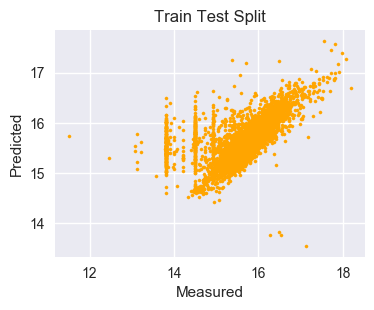

In [47]:
X_test_constant = smf.add_constant(X_test) 

pred = results.predict(X_test_constant)

fig  = plt.figure(figsize=(4, 3), dpi=100);

axes1 = fig.add_subplot(111); 
axes1.scatter(y_test, pred, c='orange', s=5)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

# Linear Regression

Ordinary least-squares linear regression without regularization. 

Fitting took 0.2658805847167969 s
Cross-val predict took 1.4993228912353516 s


Train Test Split
MAE: 0.298890047208
MSE: 0.245920953196
RMSE: 0.495904177434


Cross Validation
MAE: 0.296351793813
MSE: 0.235269204174
RMSE: 0.485045569173


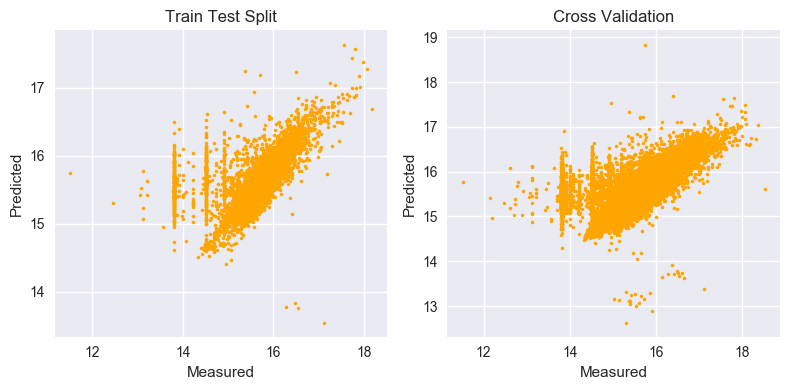

In [48]:
lr = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=-1);

start_time = time();
lr.fit(X_train, y_train);
print("Fitting took " + str(time()-start_time) + " s")

pred1 = lr.predict(X_test);

start_time = time()
pred2 = cross_val_predict(lr, scaled_train, train_df['price_doc'], cv=5)
print("Cross-val predict took " + str(time()-start_time) + " s")

#scores = cross_val_score(lr, scaled_train, train_df['price_doc'],  cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

fig  = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=5)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=5)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print('\n')
print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))

print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

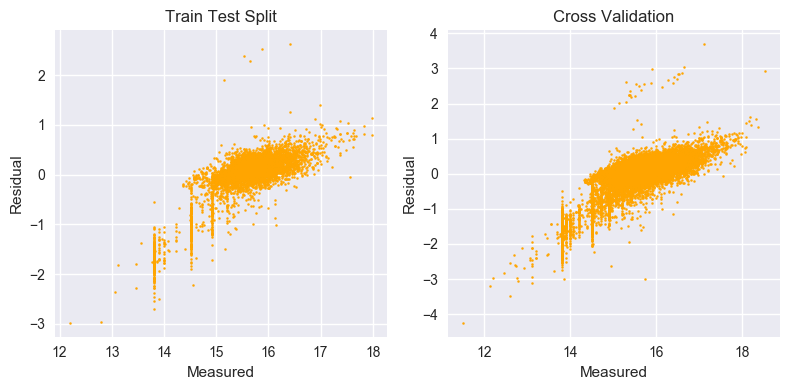

In [81]:
fig  = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, y_test-pred1, c='orange', s=2)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Residual')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'].values, train_df['price_doc']-pred2, c='orange', s=2)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Residual')

fig.tight_layout();

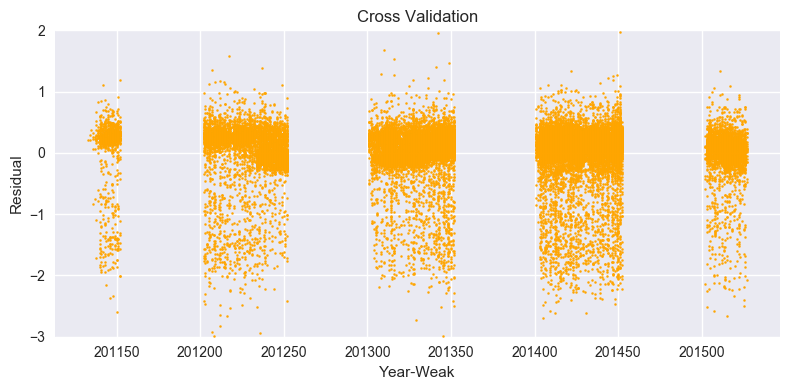

In [43]:
fig  = plt.figure(figsize=(8, 4), dpi=100);

#axes1 = fig.add_subplot(121); 
#axes1.scatter(train_df['yearweek'].values, y_test-pred1, c='orange', s=10)
#axes1.set_title("Train Test Split")
#axes1.set_xlabel('YearWeak')
#axes1.set_ylabel('Residual')

axes2 = fig.add_subplot(111); 
axes2.scatter(train_df['yearweek'].values, train_df['price_doc']-pred2, c='orange', s=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Year-Weak')
axes2.set_ylabel('Residual')

axes2.set_ylim(-3,2)

fig.tight_layout();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



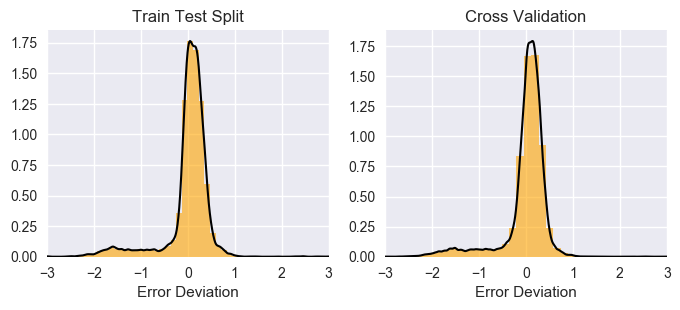

In [59]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split")
axes2.set_title("Cross Validation")

axes1.set_xlim(-3, 3);
axes2.set_xlim(-3, 3);

In [60]:
coeffecients = pd.DataFrame(lr.coef_, train_df.drop('price_doc', axis=1).columns)
coeffecients.columns = ['Coeffecient']

coeffecients.sort_values('Coeffecient', ascending=False).head(10)

,Coeffecient
work_male,4686.524512
work_female,4613.327521
ekder_all,1115.939940
young_all,577.843135
7_14_all,162.397383
children_school,162.397382
children_preschool,6.874097
0_6_all,6.874097
0_17_male,2.710793
cafe_avg_price_2000,2.159626


In [61]:
coeffecients.sort_values('Coeffecient', ascending=False).tail(10)

,Coeffecient
young_male,-3.671961
0_17_all,-3.980417
0_6_male,-6.617872
0_6_female,-6.865751
ekder_male,-63.651945
ekder_female,-143.238128
7_14_female,-157.693200
7_14_male,-167.524057
raion_popul,-3996.006747
work_all,-6687.263649


In [320]:
param_grid = [{'fit_intercept': [True, False],
              'normalize':     [True, False]}]


grid = GridSearchCV(lr, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

[  3.58356120e-01   3.27447618e-01  -6.65525610e+02  -6.65525610e+02]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [121]:
lr.fit(scaled_train, train_df['price_doc'].values)

submission = pd.DataFrame({
        "id": test_id,
        "price_doc": np.maximum(np.exp(lr.predict(scaled_test))-1, 0)
    })

submission.to_csv('submissions/17_05_14_lr_submission.csv', index=False)

# Ridge (StatsModel)

In [57]:
results = smf.OLS(y_train, X_train_constant).fit_regularized(L1_wt=0, alpha=0.0001)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     134.4
Date:                Tue, 16 May 2017   Prob (F-statistic):               0.00
Time:                        22:09:03   Log-Likelihood:                -16464.
No. Observations:               24376   AIC:                         3.315e+04
Df Residuals:                   24266   BIC:                         3.404e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         15.6096      0.003   5112.015      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1263: RuntimeWarning:

invalid value encountered in sqrt



In [56]:
results = smf.OLS(y_train, X_train_constant).fit_regularized(L1_wt=0, alpha=0.001)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     133.9
Date:                Tue, 16 May 2017   Prob (F-statistic):               0.00
Time:                        20:43:15   Log-Likelihood:                -16479.
No. Observations:               24376   AIC:                         3.318e+04
Df Residuals:                   24266   BIC:                         3.407e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         15.5955      0.003   5104.172      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1263: RuntimeWarning:

invalid value encountered in sqrt



In [53]:
results = smf.OLS(y_train, X_train_constant).fit_regularized(L1_wt=0, alpha=0.01)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     99.49
Date:                Tue, 16 May 2017   Prob (F-statistic):               0.00
Time:                        20:09:55   Log-Likelihood:                -17717.
No. Observations:               24376   AIC:                         3.565e+04
Df Residuals:                   24266   BIC:                         3.655e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         15.4564      0.003   4808.086      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1263: RuntimeWarning:

invalid value encountered in sqrt



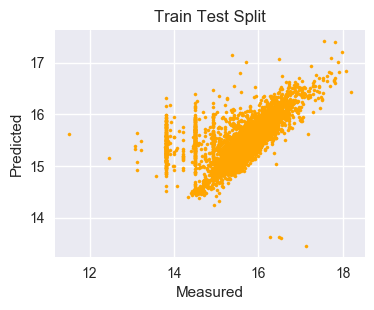

In [55]:
pred = results.predict(X_test_constant)

fig  = plt.figure(figsize=(4, 3), dpi=100);

axes1 = fig.add_subplot(111); 
axes1.scatter(y_test, pred, c='orange', s=5)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

# Ridge Regression (L2 Regularization)

Linear-least-squares with an l2-norm term for regularization.

Fitting took 0.06754565238952637 s
Crossval took 0.8105447292327881 s


Train Test Split
MAE: 0.285393656485
MSE: 0.217585394368
RMSE: 0.466460496043


Cross Validation
MAE: 0.295243228796
MSE: 0.233646263637
RMSE: 0.483369696648


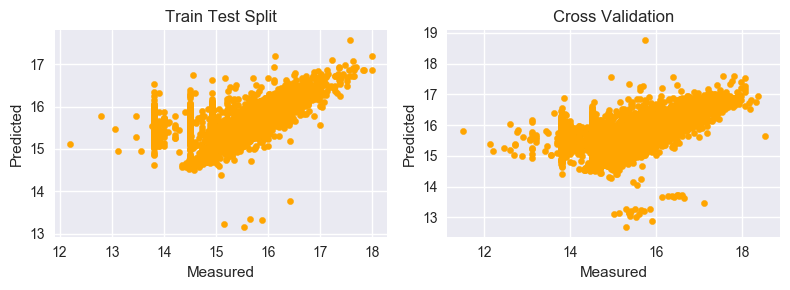

In [82]:
ridge = Ridge(alpha=60, copy_X=False, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

start_time = time()
ridge.fit(X_train, y_train);
print("Fitting took " + str(time()-start_time) + " s")

pred1 = ridge.predict(X_test);

start_time = time()
pred2 = cross_val_predict(ridge, scaled_train, train_df['price_doc'], cv=5)
print("Crossval took " + str(time()-start_time) + " s")
print('\n')

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

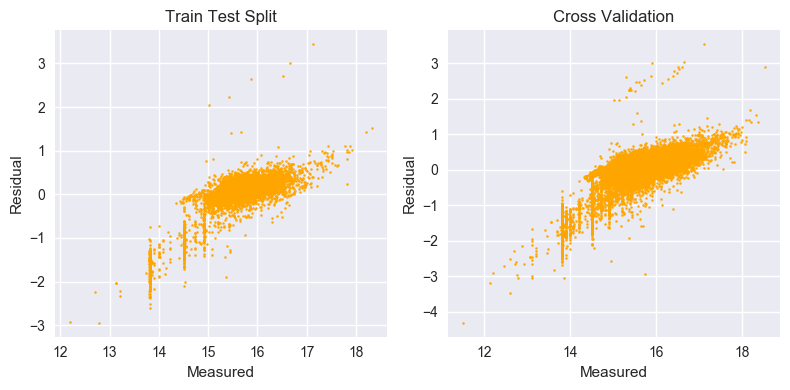

In [50]:
fig  = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, y_test-pred1, c='orange', s=2)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Residual')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'].values, train_df['price_doc']-pred2, c='orange', s=2)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Residual')

fig.tight_layout();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



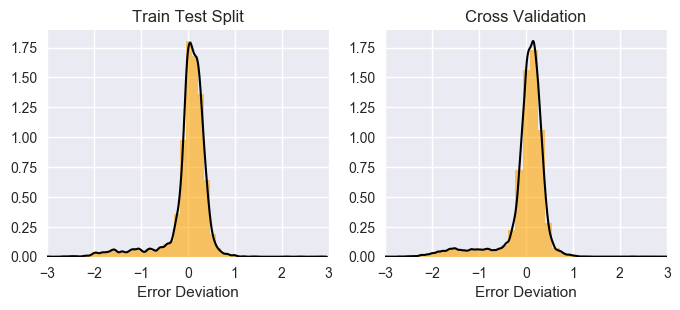

In [342]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split");
axes2.set_title("Cross Validation");

axes1.set_xlim(-3, 3);
axes2.set_xlim(-3, 3);

[ 0.35755467  0.35770996  0.35794923  0.35796903  0.35797439  0.35796947
  0.35791706  0.35777258  0.35760667  0.35727416]


Ridge(alpha=60, copy_X=False, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

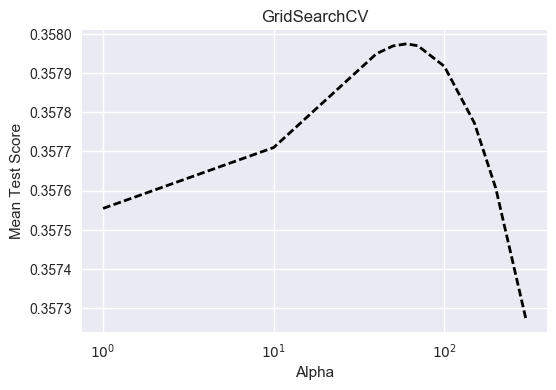

In [347]:
param_grid = [{'alpha': [1, 10, 40, 50, 60, 70, 100, 150, 200, 300]}]
               
grid = GridSearchCV(ridge, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

fig  = plt.figure(figsize=(6, 4), dpi=100);
axes1 = fig.add_subplot(111); 
axes1.plot(param_grid[0]['alpha'], grid.cv_results_['mean_test_score'], 'k--', lw=2)
axes1.set_xscale("log")
axes1.set_title("GridSearchCV")
axes1.set_xlabel('Alpha')
axes1.set_ylabel('Mean Test Score')

grid.best_estimator_

In [345]:
param_grid = [{'copy_X': [False, True],
               'fit_intercept': [False, True],
               'normalize': [False, True]}]
               
grid = GridSearchCV(ridge, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

[ -6.63859663e+02  -6.63859663e+02   3.57974387e-01   7.44283963e-02
  -6.63859663e+02  -6.63859663e+02   3.57974387e-01   7.44283963e-02]


Ridge(alpha=60, copy_X=False, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge picked 190 variables and eliminated the other 0 variables


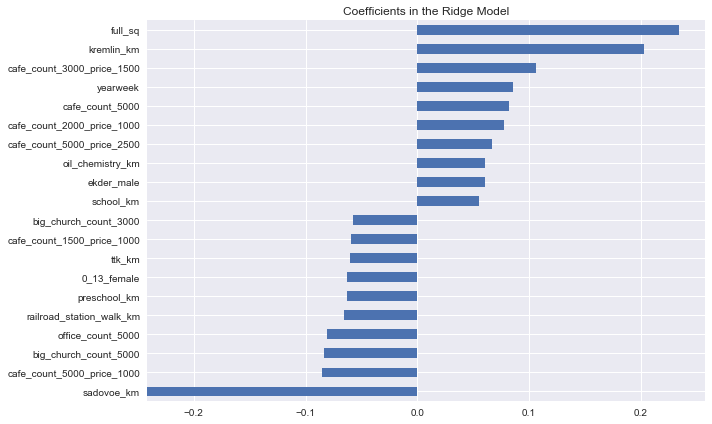

In [344]:
coef = pd.Series(ridge.coef_, index = train_df.drop('price_doc', axis=1).columns)

print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

plt.rcParams['figure.figsize'] = (10, 7)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [156]:
print('full_sq correlation: ' + str(train_df['full_sq'].corr(train_df['price_doc'])))
print('cafe_count_5000 correlation: ' + str(train_df['cafe_count_5000'].corr(train_df['price_doc'])))
print('life_sq correlation: ' + str(train_df['life_sq'].corr(train_df['price_doc'])))

full_sq correlation: 0.460079006216
cafe_count_5000 correlation: 0.27325410238
life_sq correlation: 0.260059515522


In [123]:
ridge.fit(scaled_train, train_df['price_doc'].values)

submission = pd.DataFrame({
        "id": test_id,
        "price_doc": np.maximum(np.exp(ridge.predict(scaled_test))-1, 0)
    })

submission.to_csv('submissions/17_05_14_ridge_submission.csv', index=False)

# Lasso (StatsModel)

In [41]:
results = smf.OLS(y_train, X_train).fit_regularized(L1_wt=1, alpha=0.001)

print(results.summary())

KeyboardInterrupt: 

In [ ]:
pred = results.predict(X_test)

fig  = plt.figure(figsize=(4, 3), dpi=100);

axes1 = fig.add_subplot(111); 
axes1.scatter(y_test, pred, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

# Lasso (L1 Regularization)

Linear model with L1 prior as regularizer.

Fitting took 3.224844455718994 s
Crossval took 15.430875301361084 s
Train Test Split
MAE: 0.285518554672
MSE: 0.217352729465
RMSE: 0.466211035332


Cross Validation
MAE: 0.295006444299
MSE: 0.233634565931
RMSE: 0.483357596332


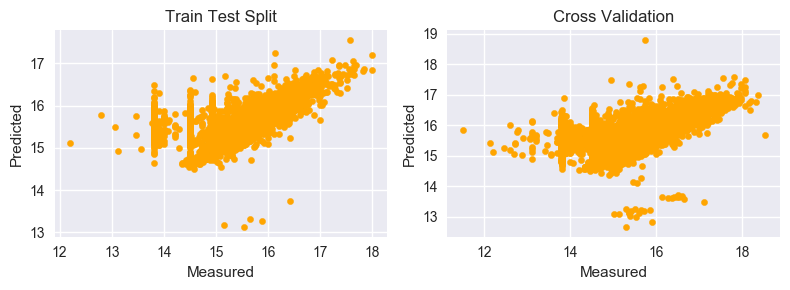

In [83]:
lasso = Lasso(alpha=0.001);

start_time = time();
lasso.fit(X_train, y_train);
print("Fitting took " + str(time()-start_time) + " s")

pred1 = lasso.predict(X_test);

start_time = time();
pred2 = cross_val_predict(lasso, scaled_train, train_df['price_doc'], cv=5)
print("Crossval took " + str(time()-start_time) + " s")

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

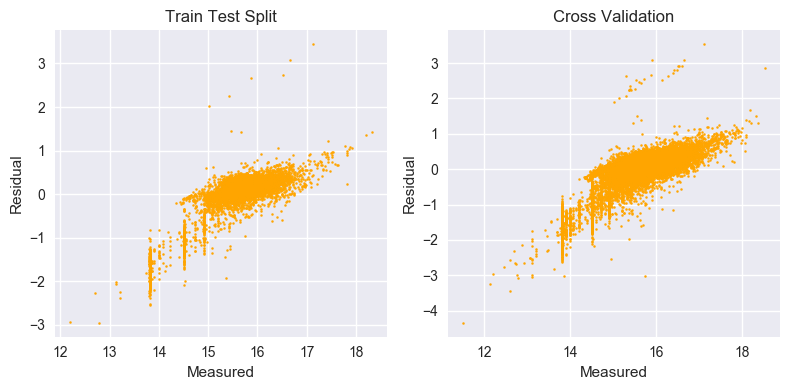

In [52]:
fig  = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, y_test-pred1, c='orange', s=2)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Residual')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'].values, train_df['price_doc']-pred2, c='orange', s=2)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Residual')

fig.tight_layout();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



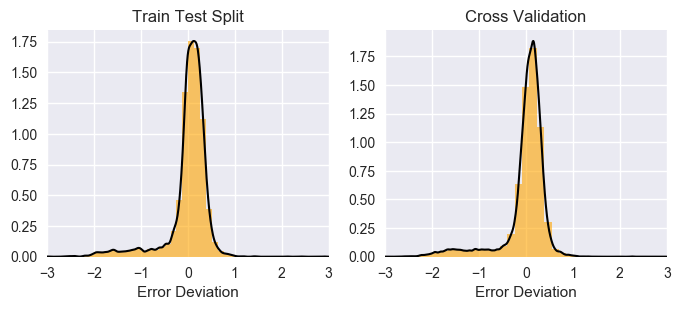

In [361]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split");
axes2.set_title("Cross Validation");

axes1.set_xlim(-3, 3);
axes2.set_xlim(-3, 3);

[ 0.35844056  0.35829655  0.35017357  0.33753495  0.29648026  0.23394042]


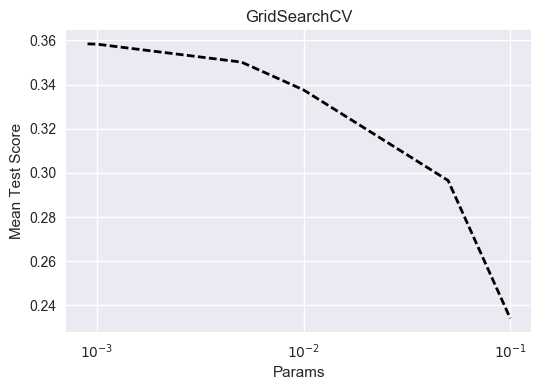

In [359]:
param_grid = [{'alpha': [0.0009, 0.001, 0.005, 0.01, 0.05, 0.1]}]

grid = GridSearchCV(lasso, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

fig  = plt.figure(figsize=(6, 4), dpi=100);
axes1 = fig.add_subplot(111); 
axes1.plot(param_grid[0]['alpha'], grid.cv_results_['mean_test_score'], 'k--', lw=2)
axes1.set_xscale("log")
axes1.set_title("GridSearchCV")
axes1.set_xlabel('Alpha')
axes1.set_ylabel('Mean Test Score')

In [ ]:
param_grid = [{'copy_X': [False, True],
               'fit_intercept': [False, True],
               'normalize': [False, True]}]
               
grid = GridSearchCV(lasso, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

Lasso picked 97 variables and eliminated the other 93 variables


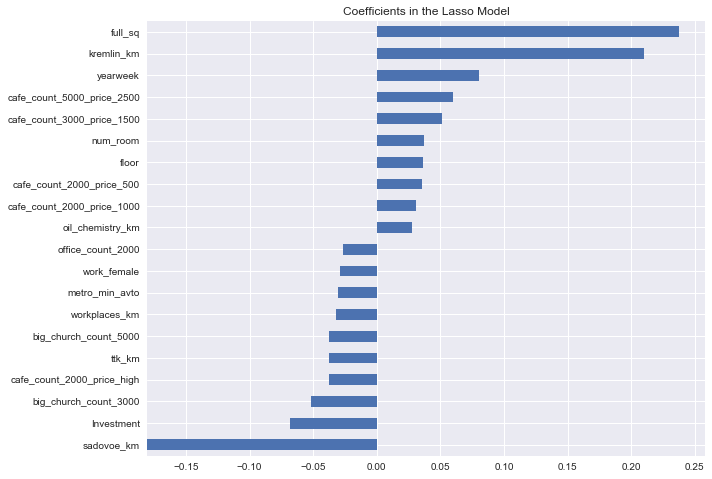

In [363]:
coef = pd.Series(lasso.coef_, index = train_df.drop('price_doc', axis=1).columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

plt.rcParams['figure.figsize'] = (10, 8)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [125]:
lasso.fit(scaled_train, train_df['price_doc'].values)

submission = pd.DataFrame({
        "id": test_id,
        "price_doc": np.maximum(np.exp(lasso.predict(scaled_test))-1, 0)
    })

submission.to_csv('submissions/17_05_14_lasso_submission.csv', index=False)

# Polynomial + XGBoost

Transformation into a polynomial features. Followed with XGBoost regression.

In [ ]:
pnr = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', xgb.XGBRegressor())])

pnr.fit(X_train, y_train);

pred1 = pnr.predict(X_test);
pred2 = cross_val_predict(pnr, train_df.drop('price_doc', axis=1), df['SalePrice'], cv=5)

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

In [ ]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),       bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split")
axes2.set_title("Cross Validation")

In [ ]:
param_grid = [{'alpha': [0.01, 0.1, 1, 10, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 500, 1000]}]

grid = GridSearchCV(pnr, param_grid, cv=10)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

# ElasticNet (L1 & L2 Regularization)

Linear regression, with a linear combination of L1 and L2 regularization terms. Overcomes limitations associated with only each term.

L1 isn't effective for high-dimensional data with few examples.

L2 makes the loss-function convex, with a unique minimum.

Fitting took 1.4249660968780518 s
Crossval took 8.8399338722229 s


Train Test Split
MAE: 0.281273439132
MSE: 0.205202037453
RMSE: 0.452992315004


Cross Validation
MAE: 0.29418019943
MSE: 0.238309121379
RMSE: 0.488169152425


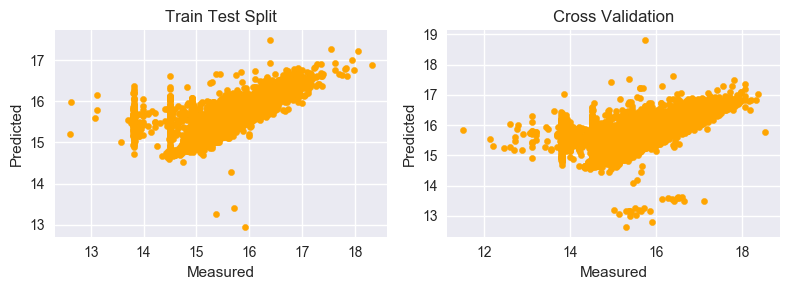

In [369]:
ela = ElasticNet(alpha=0.01)

start_time = time();
ela.fit(X_train, y_train);
print("Fitting took " + str(time()-start_time) + " s");

pred1 = ela.predict(X_test);

start_time = time();
pred2 = cross_val_predict(ela, scaled_train, train_df['price_doc'], cv=5)
print("Crossval took " + str(time()-start_time) + " s")
print('\n');

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



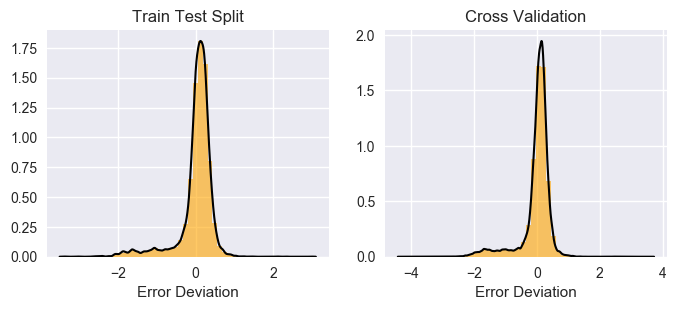

In [370]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split")
axes2.set_title("Cross Validation")

[ 0.34974477  0.32182812  0.29333829]


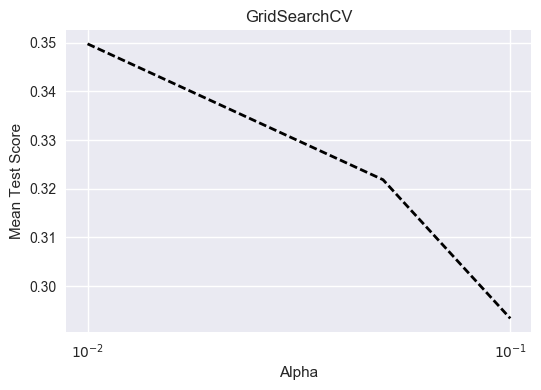

In [368]:
param_grid = [{'alpha': [0.01, 0.05, 0.1]}]

grid = GridSearchCV(ela, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

fig  = plt.figure(figsize=(6, 4), dpi=100);
axes1 = fig.add_subplot(111); 
axes1.plot(param_grid[0]['alpha'], grid.cv_results_['mean_test_score'], 'k--', lw=2)
axes1.set_xscale("log")
axes1.set_title("GridSearchCV")
axes1.set_xlabel('Alpha')
axes1.set_ylabel('Mean Test Score')

[ 0.35744493  0.35493208  0.34974477  0.34339856  0.33986627]


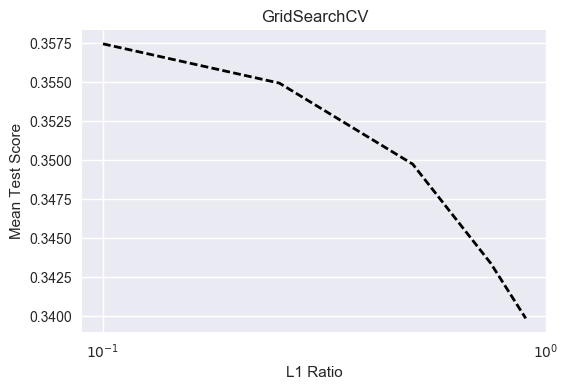

In [373]:
param_grid = [{'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]}]

#grid = GridSearchCV(ela, param_grid, cv=5)

#grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

fig  = plt.figure(figsize=(6, 4), dpi=100);
axes1 = fig.add_subplot(111); 
axes1.plot(param_grid[0]['l1_ratio'], grid.cv_results_['mean_test_score'], 'k--', lw=2)
axes1.set_xscale("log")
axes1.set_title("GridSearchCV")
axes1.set_xlabel('L1 Ratio')
axes1.set_ylabel('Mean Test Score')

ElasticNet picked 55 variables and eliminated the other 135 variables


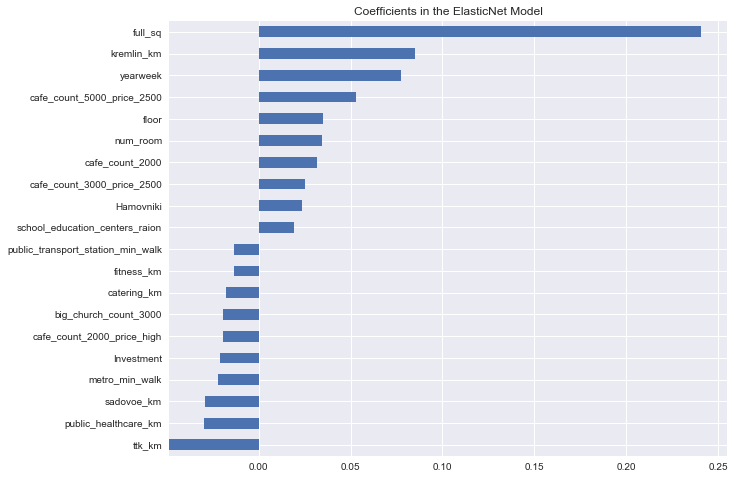

In [375]:
coef = pd.Series(ela.coef_, index = train_df.drop('price_doc', axis=1).columns)

print("ElasticNet picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

plt.rcParams['figure.figsize'] = (10, 8)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")

# Theil-Sen Regressor

A robust multivariate regression model. Least-squares on subsets with size n_subsamples. Any value of n_subsamples between the number of features and samples leads to an estimator with a compromise between robustness and efficiency. 

Fitting took 142.83508920669556 s
Crossval took 755.3100738525391 s


Train Test Split
MAE: 0.401428953173
MSE: 0.909197098849
RMSE: 0.953518273999


Cross Validation
MAE: 0.386343889716
MSE: 0.746288695018
RMSE: 0.863880023509


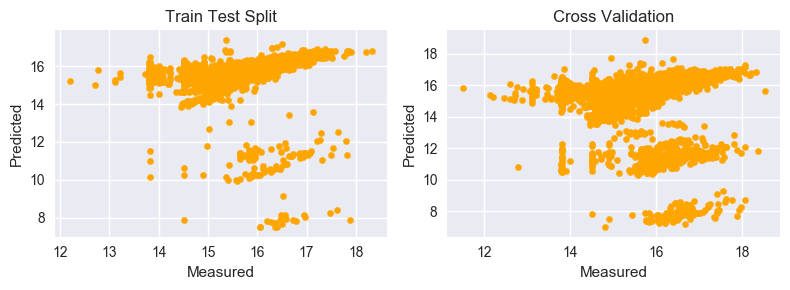

In [16]:
tsr = TheilSenRegressor()

start_time = time();
tsr.fit(X_train, y_train);
print("Fitting took " + str(time()-start_time) + " s");

pred1 = tsr.predict(X_test);

start_time = time();
pred2 = cross_val_predict(tsr, scaled_train, train_df['price_doc'], cv=5)
print("Crossval took " + str(time()-start_time) + " s")
print('\n');

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

In [ ]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split")
axes2.set_title("Cross Validation")

In [ ]:
param_grid = [{'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]}]

grid = GridSearchCV(tsr, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

fig  = plt.figure(figsize=(6, 4), dpi=100);
axes1 = fig.add_subplot(111); 
axes1.plot(param_grid[0]['l1_ratio'], grid.cv_results_['mean_test_score'], 'k--', lw=2)
axes1.set_xscale("log")
axes1.set_title("GridSearchCV")
axes1.set_xlabel('L1 Ratio')
axes1.set_ylabel('Mean Test Score')

# Bayesian Ridge Regression

Fitting took 0.951326847076416 s
Crossval took 3.8740875720977783 s


Train Test Split
MAE: 0.291300181785
MSE: 0.22999075385
RMSE: 0.479573512457


Cross Validation
MAE: 0.294332945342
MSE: 0.232991388186
RMSE: 0.482691814915


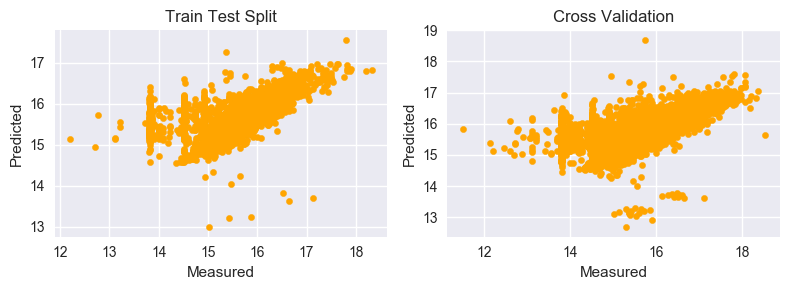

In [17]:
brr = BayesianRidge()

start_time = time();
brr.fit(X_train, y_train);
print("Fitting took " + str(time()-start_time) + " s");

pred1 = brr.predict(X_test);

start_time = time();
pred2 = cross_val_predict(brr, scaled_train, train_df['price_doc'], cv=5)
print("Crossval took " + str(time()-start_time) + " s")
print('\n');

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



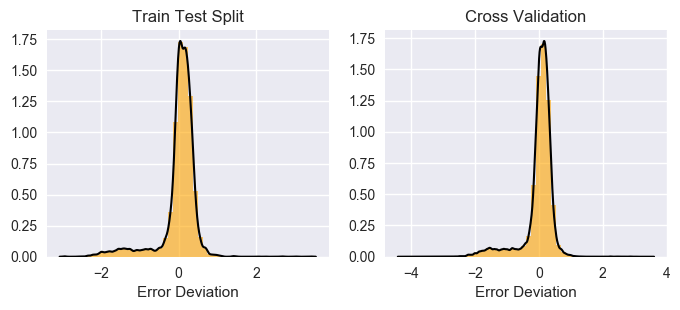

In [18]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split")
axes2.set_title("Cross Validation")

In [ ]:
param_grid = [{'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]}]

grid = GridSearchCV(brr, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

fig  = plt.figure(figsize=(6, 4), dpi=100);
axes1 = fig.add_subplot(111); 
axes1.plot(param_grid[0]['l1_ratio'], grid.cv_results_['mean_test_score'], 'k--', lw=2)
axes1.set_xscale("log")
axes1.set_title("GridSearchCV")
axes1.set_xlabel('L1 Ratio')
axes1.set_ylabel('Mean Test Score')

# Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 14.7min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting took 882.4054391384125 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.6min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.3min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.4min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Crossval took 1878.5361924171448 s


Train Test Split
MAE: 0.252622160927
MSE: 0.248954031926
RMSE: 0.498952935582


Cross Validation
MAE: 0.283214740211
MSE: 0.269196634571
RMSE: 0.518841627639


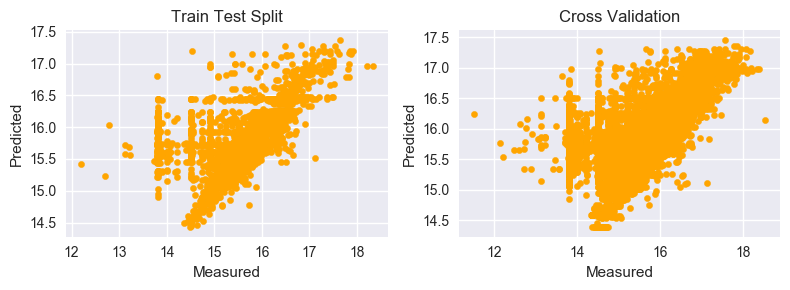

In [53]:
rfr = RandomForestRegressor(criterion='mae', max_depth=6, verbose=1,
           max_features='auto', min_samples_leaf=9, n_estimators=10, n_jobs=-1)

start_time = time()
rfr.fit(X_train, y_train);
print("Fitting took " + str(time()-start_time) + " s")

pred1 = rfr.predict(X_test);

start_time = time()
pred2 = cross_val_predict(rfr, scaled_train, train_df['price_doc'], cv=3)
print("Crossval took " + str(time()-start_time) + " s")
print('\n');

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

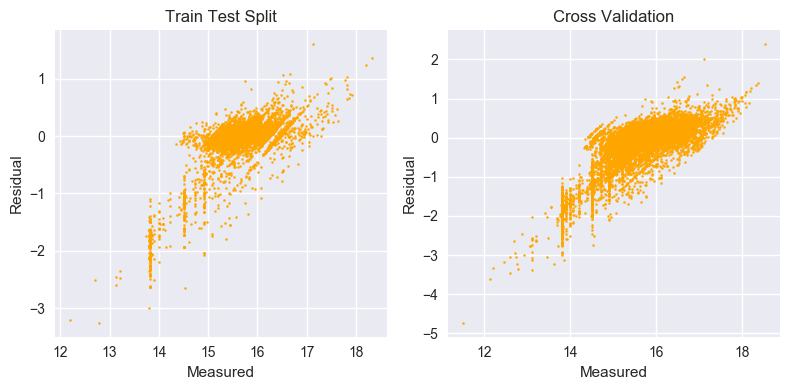

In [54]:
fig  = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, y_test-pred1, c='orange', s=2)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Residual')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'].values, train_df['price_doc']-pred2, c='orange', s=2)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Residual')

fig.tight_layout();

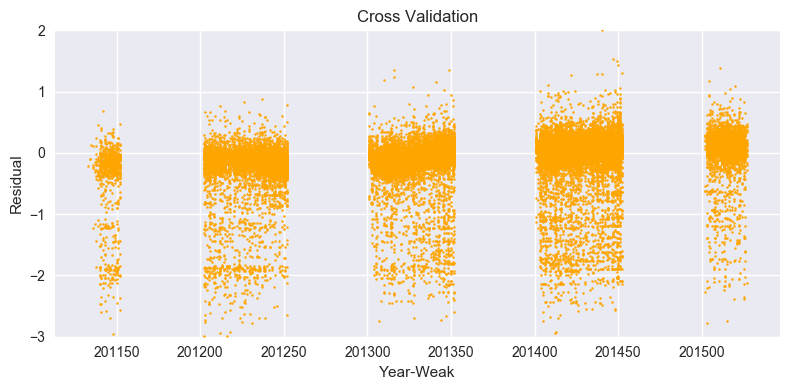

In [55]:
fig  = plt.figure(figsize=(8, 4), dpi=100);

#axes1 = fig.add_subplot(121); 
#axes1.scatter(train_df['yearweek'].values, y_test-pred1, c='orange', s=10)
#axes1.set_title("Train Test Split")
#axes1.set_xlabel('YearWeak')
#axes1.set_ylabel('Residual')

axes2 = fig.add_subplot(111); 
axes2.scatter(train_df['yearweek'].values, train_df['price_doc']-pred2, c='orange', s=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Year-Weak')
axes2.set_ylabel('Residual')

axes2.set_ylim(-3,2)

fig.tight_layout();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



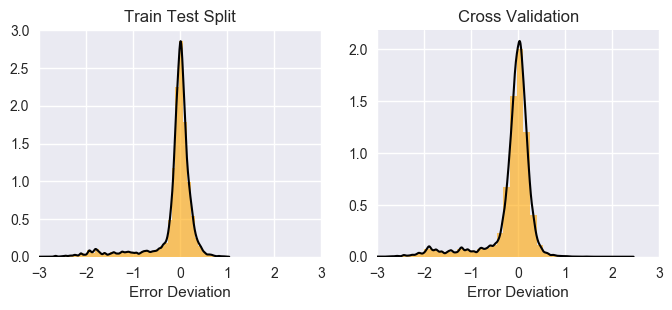

In [28]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split");
axes2.set_title("Cross Validation");

axes1.set_xlim(-3, 3);
axes2.set_xlim(-3, 3);

[ 0.07512274  0.16464335  0.23765675  0.30801564  0.33658394]


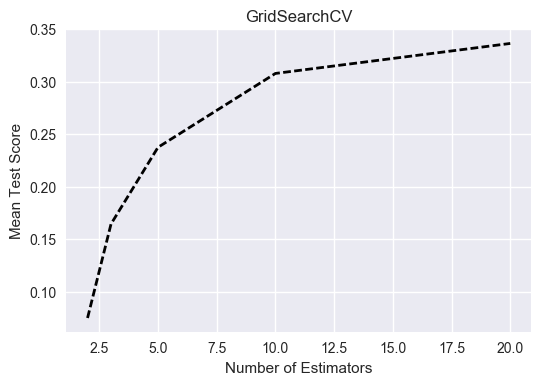

In [394]:
param_grid = [{'n_estimators': [2, 3, 5, 10, 20]}]

grid = GridSearchCV(rfr, param_grid, cv=3)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

fig  = plt.figure(figsize=(6, 4), dpi=100);
axes1 = fig.add_subplot(111); 
axes1.plot(param_grid[0]['n_estimators'], grid.cv_results_['mean_test_score'], 'k--', lw=2)
#axes1.set_xscale("log")
axes1.set_title("GridSearchCV")
axes1.set_xlabel('Number of Estimators')
axes1.set_ylabel('Mean Test Score')

In [29]:
param_grid = [{'n_estimators': [5],
               'max_depth': [3, 4, 6, 8],
               'min_samples_leaf': [5, 9, 15], 
               'criterion': ['mse', 'mae']
              }]

grid = GridSearchCV(rfr, param_grid, cv=3)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

building tree 1 of 5building tree 3 of 5building tree 4 of 5building tree 2 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 3 of 5building tree 4 of 5building tree 2 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 4 of 5building tree 2 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 2 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 4 of 5building tree 3 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 4 of 5building tree 2 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 4 of 5building tree 2 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 4 of 5building tree 2 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 3 of 5building tree 4 of 5building tree 2 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5
building tree 4 of 5building tree 2 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 4 of 5building tree 2 of 5building tree 3 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 3 of 5building tree 4 of 5building tree 2 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 3 of 5building tree 2 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 2 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 3 of 5building tree 2 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 4 of 5building tree 3 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5
building tree 2 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 2 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 2 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 4 of 5building tree 3 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5
building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 2 of 5building tree 4 of 5building tree 3 of 5building tree 1 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5
building tree 4 of 5building tree 3 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.3min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.2min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 3 of 5building tree 4 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5
building tree 2 of 5building tree 4 of 5building tree 3 of 5


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 4 of 5building tree 2 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 2 of 5building tree 3 of 5building tree 4 of 5



building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


building tree 1 of 5building tree 3 of 5building tree 2 of 5building tree 4 of 5





[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s


building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


[ 0.3156559   0.31357691  0.31051949  0.3375086   0.33815046  0.33880393
  0.35906934  0.36246573  0.36350223  0.362809    0.36557062  0.37067725
  0.25793846  0.25904773  0.2611254   0.2880853   0.2858901   0.28303481
  0.31505862  0.31450161  0.31054296  0.33233806  0.33074592  0.32876293]


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=15,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=5, n_jobs=-1, oob_score=False, random_state=None,
           verbose=3, warm_start=False)

Random Forest picked 100 variables and eliminated the other 90 variables


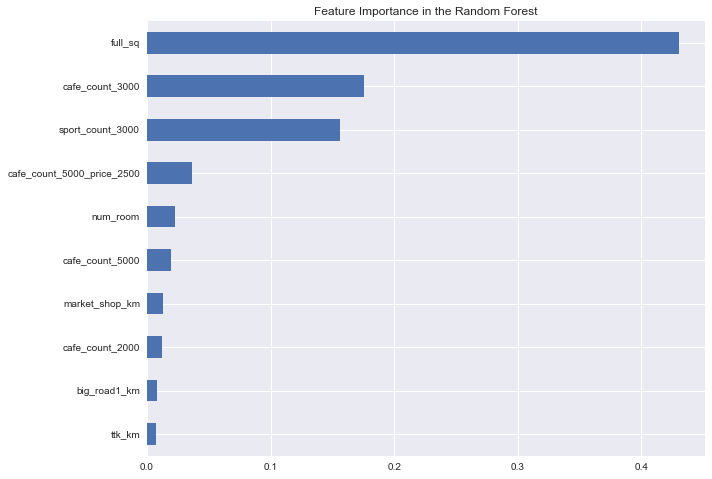

In [30]:
coef = pd.Series(rfr.feature_importances_, index = train_df.drop('price_doc', axis=1).columns)

print("Random Forest picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values(ascending=True).tail(10)])

plt.rcParams['figure.figsize'] = (10, 8)
imp_coef.plot(kind = "barh")
plt.title("Feature Importance in the Random Forest")

In [126]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=15,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
           verbose=3, warm_start=False)

rf.fit(scaled_train, train_df['price_doc'].values)

submission = pd.DataFrame({
        "id": test_id,
        "price_doc": np.maximum(np.exp(rf.predict(scaled_test))-1, 0)
    })

submission.to_csv('submissions/17_05_14_random_forest_submission.csv', index=False)

building tree 1 of 20building tree 3 of 20building tree 2 of 20building tree 4 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


# Gradient Boosting Regressor

Generalization of boosting to arbitrary differentiable loss functions.

      Iter       Train Loss   Remaining Time 
         1           0.3402           47.60s
         2           0.3230           50.63s
         3           0.3087           48.48s
         4           0.2969           47.79s
         5           0.2871           49.19s
         6           0.2787           47.99s
         7           0.2717           47.17s
         8           0.2657           46.47s
         9           0.2606           45.86s
        10           0.2559           46.36s
        20           0.2312           39.71s
        30           0.2208           33.43s
        40           0.2148           28.01s
        50           0.2110           23.12s
        60           0.2079           18.34s
        70           0.2054           13.61s
        80           0.2036            8.99s
        90           0.2018            4.46s
       100           0.1998            0.00s
Fitting took 44.94211173057556 s
      Iter       Train Loss   Remaining Time 
         1          

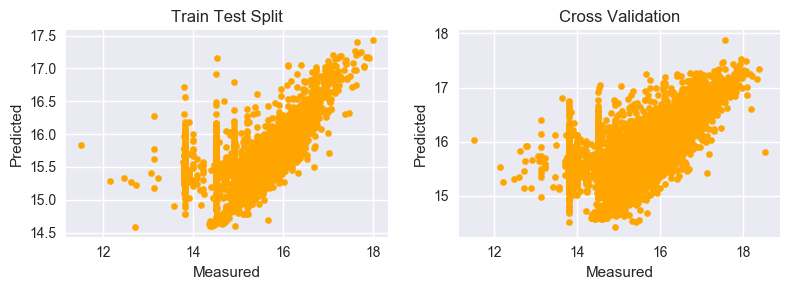

In [137]:
gbr = GradientBoostingRegressor(verbose=1);

start_time = time();
gbr.fit(X_train, y_train);
print("Fitting took " + str(time()-start_time) + " s")

pred1 = gbr.predict(X_test);

start_time = time();
pred2 = cross_val_predict(gbr, scaled_train, train_df['price_doc'], cv=3)
print("Crossval took " + str(time()-start_time) + " s")
print('\n');

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



(-3, 3)

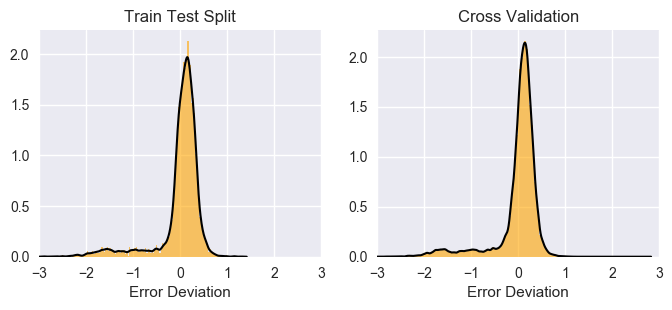

In [134]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=200, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize": 1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=200, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize": 1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split")
axes2.set_title("Cross Validation")

axes1.set_xlim(-3, 3)
axes2.set_xlim(-3, 3)

In [135]:
coeffecients = pd.DataFrame(gbr.feature_importances_, train_df.drop('price_doc', axis=1).columns)
coeffecients.columns = ['Coeffecient']

coeffecients.sort_values('Coeffecient', ascending=False).head(10)

,Coeffecient
full_sq,0.219826
yearweek,0.081792
floor,0.032430
state,0.024437
additional_education_km,0.020748
railroad_station_avto_km,0.019674
ttk_km,0.016663
power_transmission_line_km,0.016283
cafe_count_5000_price_high,0.012431
kitch_sq,0.012350


      Iter       Train Loss   Remaining Time 
         1           0.3433            0.26s
         2           0.3261            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.3409            0.25s
         2           0.3230            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.3363            0.37s
         2           0.3196            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.3433            0.50s
         2           0.3261            0.25s
         3           0.3116            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.3409            0.64s
         2           0.3230            0.32s
         3           0.3083            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.3363            0.58s
         2           0.3196            0.32s
         3           0.3057            0.00s
      Iter       Train Loss   Remaining Time 
   

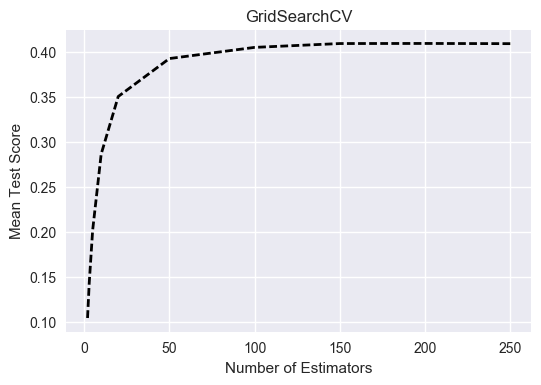

In [138]:
param_grid = [{'n_estimators': [2, 3, 5, 10, 20, 50, 100, 150, 200, 250]}]

grid = GridSearchCV(gbr, param_grid, cv=3)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

fig  = plt.figure(figsize=(6, 4), dpi=100);
axes1 = fig.add_subplot(111); 
axes1.plot(param_grid[0]['n_estimators'], grid.cv_results_['mean_test_score'], 'k--', lw=2)
#axes1.set_xscale("log")
axes1.set_title("GridSearchCV")
axes1.set_xlabel('Number of Estimators')
axes1.set_ylabel('Mean Test Score')

In [ ]:
param_grid = [{'n_estimators': [50],
               'learning_rate': [0.1, 0.05, 0.02, 0.01],
               'max_depth': [3, 4, 6, 8],
               'min_samples_leaf': [3, 5, 9, 15], 
               'criterion': ['mse', 'mae'],
               'max_features': ['auto', 'sqrt', 'log2']
              }]

grid = GridSearchCV(gbr, param_grid, cv=3)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

      Iter       Train Loss   Remaining Time 
         1           0.3433           16.16s
         2           0.3261           14.96s
         3           0.3116           14.46s
         4           0.2996           14.02s
         5           0.2897           13.57s
         6           0.2809           13.30s
         7           0.2736           13.01s
         8           0.2671           12.69s
         9           0.2619           12.73s
        10           0.2574           13.10s
        20           0.2314            9.36s
        30           0.2204            6.03s
        40           0.2142            2.93s
        50           0.2100            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.3409           14.42s
         2           0.3230           14.01s
         3           0.3083           13.83s
         4           0.2964           13.58s
         5           0.2861           13.28s
         6           0.2775           12.95s
        

# AdaBoost

Adaptive boosting of a decision tree regressor. A regressor is fit on the original data set. Additional copies of the regressor are then fit, with weights adjusted according to the error of the current prediciton.

Train Test Split
MAE: 0.662842203712
MSE: 0.546447455701
RMSE: 0.73922084366


Cross Validation
MAE: 0.644805150505
MSE: 0.520156382126
RMSE: 0.721218678437


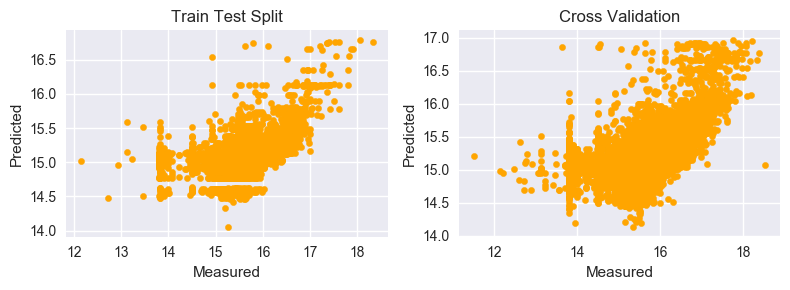

In [31]:
ada = AdaBoostRegressor();

ada.fit(X_train, y_train);

pred1 = ada.predict(X_test);
#pred2 = cross_val_predict(ada, df.drop('SalePrice', axis=1), df['SalePrice'], cv=10)
pred2 = cross_val_predict(ada, scaled_train, train_df['price_doc'], cv=10)

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



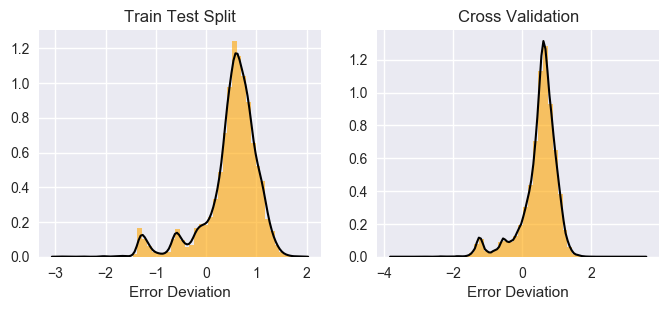

In [32]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split")
axes2.set_title("Cross Validation")

[ 0.81088586  0.85498981  0.86844065  0.87379505  0.87601368  0.8764839
  0.87743994  0.87968751  0.87878665  0.87870176  0.87840358]


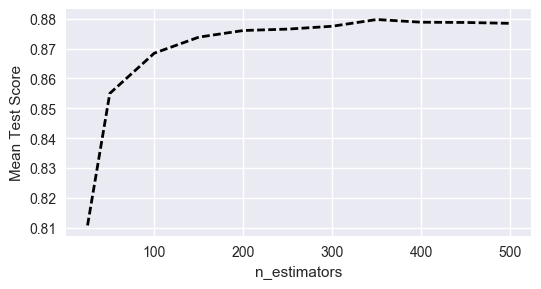

In [50]:
param_grid = [{'n_estimators': [25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
              }]

grid = GridSearchCV(gbr, param_grid, cv=10)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

fig  = plt.figure(figsize=(6, 3), dpi=100);
axes1 = fig.add_subplot(111); 
axes1.plot(param_grid[0]['n_estimators'], grid.cv_results_['mean_test_score'], 'k--', lw=2)
axes1.set_xlabel('n_estimators')
axes1.set_ylabel('Mean Test Score')

# XGBoost

Gradient boosting, scalable to extremely large datasets.

Train Test Split
MAE: 0.335694748378
MSE: 0.240173589545
RMSE: 0.49007508562


Cross Validation
MAE: 0.328696050272
MSE: 0.230579492443
RMSE: 0.480186934894


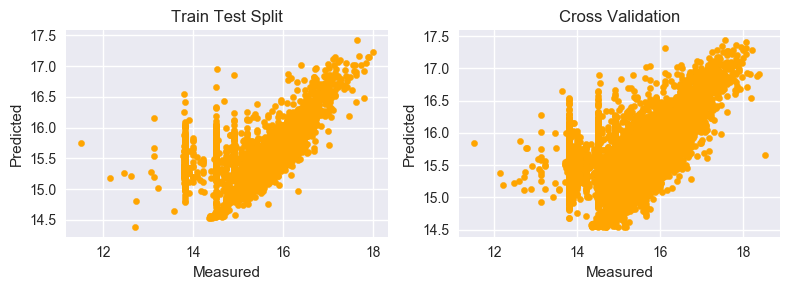

In [127]:
xgr = xgb.XGBRegressor(learning_rate=0.05, max_depth=5, colsample_bytree=0.7, silent=False)

xgr.fit(X_train, y_train, verbose=True, eval_metric='rmse');

pred1 = xgr.predict(X_test);
#pred2 = cross_val_predict(ela, df.drop('SalePrice', axis=1), df['SalePrice'], cv=5)
pred2 = cross_val_predict(xgr, scaled_train, train_df['price_doc'], cv=5)

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



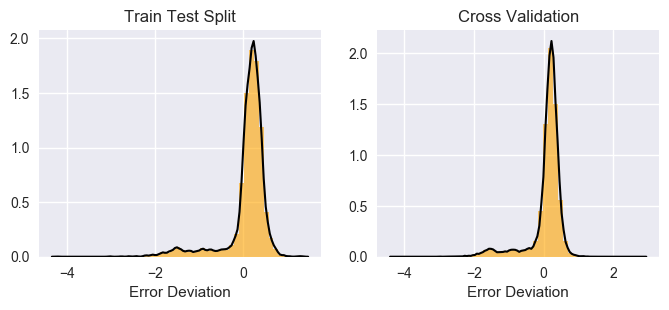

In [128]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_test-pred1),                bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((train_df['price_doc']-pred2), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split")
axes2.set_title("Cross Validation")

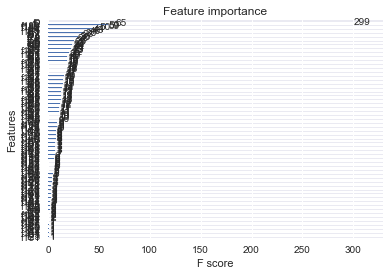

In [208]:
xgb.plot_importance(xgr)

In [16]:
param_grid = [{'max_depth': [5, 10, 20],
               'learning_rate': [0.01, 0.1, 1],
               'n_estimators':  [50, 100, 200]
              }]

grid = GridSearchCV(xgr, param_grid, cv=10)

grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])

grid.best_estimator_

[ 0.85881696  0.86529535  0.86947647]


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [129]:
xgr.fit(scaled_train, train_df['price_doc'].values)

submission = pd.DataFrame({
        "id": test_id,
        "price_doc": np.maximum(np.exp(xgr.predict(scaled_test))-1, 0)
    })

submission.to_csv('submissions/17_05_14_xgboost_submission.csv', index=False)

# XGBoost (without sklearn wrapper)

In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2);

dtrain = xgb.DMatrix(X_train2, y_train2, feature_names=train_df.drop('price_doc', axis=1).columns)
dval   = xgb.DMatrix(X_val,    y_val,    feature_names=train_df.drop('price_doc', axis=1).columns)
dtest  = xgb.DMatrix(X_test,             feature_names=train_df.drop('price_doc', axis=1).columns)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [35]:
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.3772
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:5.18562
[40]	val-rmse:1.92233
[60]	val-rmse:0.822751
[80]	val-rmse:0.525256
[100]	val-rmse:0.46839
[120]	val-rmse:0.457309
[140]	val-rmse:0.45498
[160]	val-rmse:0.453993
[180]	val-rmse:0.453378
[200]	val-rmse:0.453105
[220]	val-rmse:0.452755
[240]	val-rmse:0.452795
Stopping. Best iteration:
[226]	val-rmse:0.452645



Train Test Split
MAE: 0.275271355189
MSE: 0.216492446259
RMSE: 0.465287487752


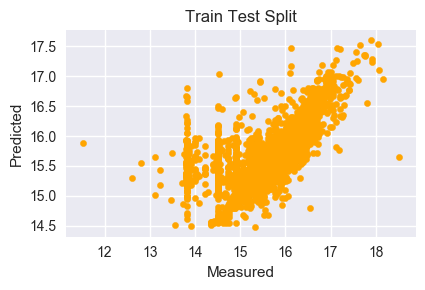

In [43]:
pred1 = partial_model.predict(dtest);
#pred2 = cross_val_predict(ela, df.drop('SalePrice', axis=1), df['SalePrice'], cv=5)
#pred2 = cross_val_predict(xgr, scaled_train, train_df['price_doc'], cv=5)

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_test, pred1, c='orange', s=20)
#axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

#axes2 = fig.add_subplot(122); 
#axes2.scatter(train_df['price_doc'], pred2, c='orange', s=20)
#axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
#axes2.set_title("Cross Validation")
#axes2.set_xlabel('Measured')
#axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_test, pred1))
print('MSE:',          mean_squared_error( y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_test, pred1)))
#print('\n')
#print("Cross Validation")
#print('MAE:',          mean_absolute_error(train_df['price_doc'], pred2))
#print('MSE:',          mean_squared_error( train_df['price_doc'], pred2))
#print('RMSE:', np.sqrt(mean_squared_error( train_df['price_doc'], pred2)))